In [364]:
# Modues to be used
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import plot_roc_curve


from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load data from pickle files

# -> Player dictionary with the dataFrames
f = open('../data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('../data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('../data/dict_map.pickle','rb')
dict_map = pickle.load(f)

In [216]:
df_map.head()

,map_id,map,date,event_id,event_name,team_id_1,team_name_1,team_score_1,team_kills_1,team_deaths_1,team_assists_1,team_rank_1,team_id_2,team_name_2,team_score_2,team_kills_2,team_deaths_2,team_assists_2,team_rank_2,winner
12838,12838,NaN,2012-09-13 19:00:00,965,Go4CS:GO Cup #6,4411,NiP,16,91.0,46.0,0.0,0,4443,PRiME,3,45.0,91.0,0.0,0,1
12839,12839,NaN,2012-09-13 19:00:00,965,Go4CS:GO Cup #6,4411,NiP,16,83.0,34.0,0.0,0,4443,PRiME,1,34.0,83.0,0.0,0,1
12840,12840,NaN,2012-09-13 19:00:00,966,CyberGamer Qualifier Cup #1 by Tt eSPORTS,4444,Blight,16,81.0,37.0,0.0,0,4445,FMESPORTS,2,37.0,81.0,0.0,0,1
12841,12841,NaN,2012-09-13 19:00:00,966,CyberGamer Qualifier Cup #1 by Tt eSPORTS,4444,Blight,16,97.0,58.0,0.0,0,4445,FMESPORTS,7,57.0,97.0,0.0,0,1
12848,12848,NaN,2012-09-23 12:00:00,973,DreamHack Valencia 2012,4411,NiP,16,102.0,86.0,0.0,0,4467,VeryGames,10,86.0,102.0,0.0,0,1


In [348]:
DAYS_WEIGHT = 365

time_1 = datetime.now()

# If we want matches only between only ranked teams
df_tmp = df_map[ (df_map['date']>datetime(2019,1,1)) &
    ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) ) ]


df_two_year = df_map[ (df_map['date']>datetime(2018,1,1)) ]


dict_train = {}

print( len( df_tmp['map_id']) )

#2000 -> ~4min
for map_id in df_tmp['map_id'][:]:

    map_date = df_tmp.loc[map_id]['date']

    dict_train[map_id] = {}    

    # Here we are taking the rankings to be non-zero
    rank_1 = df_tmp.loc[map_id]['team_rank_1']
    rank_2 = df_tmp.loc[map_id]['team_rank_2']

    team_id_1 = df_tmp.loc[map_id]['team_id_1']
    team_id_2 = df_tmp.loc[map_id]['team_id_2']

    # # History between the two teams
    df_history = df_two_year[ 
        (df_two_year['date'] < map_date) &
        (((df_two_year['team_id_1']==team_id_1) & (df_two_year['team_id_2']==team_id_2)) | 
        ((df_two_year['team_id_2']==team_id_1) & (df_two_year['team_id_1']==team_id_2))) ]

    # Here we take the history against teams that are in a similar rank to that of the opponent
    # df_history_1 = df_two_year[ 
    #     (df_two_year['date'] < map_date) & (
    #     ((df_two_year['team_id_1']==team_id_1) & (df_two_year['team_rank_2']>(rank_2-10)) & (df_two_year['team_rank_2']<(rank_2+10)) ) | 
    #     ((df_two_year['team_id_2']==team_id_1) & (df_two_year['team_rank_1']>(rank_2-10)) & (df_two_year['team_rank_1']<(rank_2+10)) ) 
    #     ) ]

    win_vec_1 = (df_two_year[
        (df_two_year['date'] < map_date) &
        (df_two_year['team_id_1']==team_id_1) & 
        (df_two_year['team_rank_2']>(rank_2-10)) & 
        (df_two_year['team_rank_2']<(rank_2+10)) ]['winner'].values == 1)*1

    np.append( win_vec_1, 
        (df_two_year[
            (df_two_year['date'] < map_date) &
            (df_two_year['team_id_2']==team_id_1) & 
            (df_two_year['team_rank_1']>(rank_2-10)) & 
            (df_two_year['team_rank_1']<(rank_2+10)) ]['winner'].values == 2)*1
        )

    if len(win_vec_1) > 0:
        win_rate_1 = np.mean(win_vec_1) - 0.5
    else:
        win_rate_1 = 0.0
    

    win_vec_2 = (df_two_year[
        (df_two_year['date'] < map_date) &
        (df_two_year['team_id_1']==team_id_2) & 
        (df_two_year['team_rank_2']>(rank_1-10)) & 
        (df_two_year['team_rank_2']<(rank_1+10)) ]['winner'].values == 1)*1

    np.append( win_vec_2, 
        (df_two_year[
            (df_two_year['date'] < map_date) &
            (df_two_year['team_id_2']==team_id_2) & 
            (df_two_year['team_rank_1']>(rank_1-10)) & 
            (df_two_year['team_rank_1']<(rank_1+10)) ]['winner'].values == 2)*1
        )

    if len(win_vec_2) > 0:
        win_rate_2 = np.mean(win_vec_2) - 0.5
    else:
        win_rate_2 = 0.0
    
   
    # We get the scores for the matches between the two teams
    score_history_1 = df_history[ 
        (df_history['team_id_1']==team_id_1) ]['team_score_1'].values
    
    np.append( score_history_1, df_history[ 
        (df_history['team_id_2']==team_id_1) ]['team_score_2'].values )

    score_history_2 = df_history[ 
        (df_history['team_id_2']==team_id_2) ]['team_score_2'].values
    
    np.append( score_history_2, df_history[ 
        (df_history['team_id_1']==team_id_2) ]['team_score_1'].values )

    winner = df_tmp.loc[map_id]['winner']

    if rank_1 < rank_2:
        fav = 0
        dict_train[map_id]['rank_dif'] = rank_2-rank_1

        if len(score_history_1) > 0:
            dict_train[map_id]['history_dif'] = np.mean( score_history_1-score_history_2 )
        else:
            dict_train[map_id]['history_dif'] = 0.0

        dict_train[map_id]['shift_win_rate_0'] = win_rate_1
        dict_train[map_id]['shift_win_rate_1'] = win_rate_2

        if winner == 1:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    else:
        fav = 1
        dict_train[map_id]['rank_dif'] = rank_1-rank_2

        if len(score_history_1) > 0:
            dict_train[map_id]['history_dif'] = np.mean( score_history_2-score_history_1 )
        else:
            dict_train[map_id]['history_dif'] = 0.0

        dict_train[map_id]['shift_win_rate_0'] = win_rate_2
        dict_train[map_id]['shift_win_rate_1'] = win_rate_1

        if winner == 2:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    count_team = -1
    for team_id in dict_map[map_id]:

        count_team = count_team + 1
        weighted_rating    = []

        weighted_kast      = []
        weighted_kpr       = []
        weighted_round_dif = []

        prize = []

        for player_id in dict_map[map_id][team_id]['players_id']:            

            df_aux = dict_player[player_id]

            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            df_aux = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            try:
                m = float(1.0)/ sum( date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)]-DAYS_WEIGHT )
            except:
                m = 0.0

            w_i = m * (date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)] - DAYS_WEIGHT)
            
            # w_i = 1.0

            weighted_rating.append( sum(df_aux['rating'] * w_i) )
            prize.append( df_aux['prize'].sum() )

            weighted_kast.append( sum(df_aux['KAST'] * w_i / 100.0) )
            weighted_kpr.append( sum(df_aux['kills_per_round'] * w_i) )
            
            weighted_round_dif.append( sum( (df_aux['team_score']-df_aux['op_score']) * w_i) )

        order = np.argsort( weighted_rating )

        if count_team == fav:
            count_p = -1
            for ind in order:
                count_p = count_p + 1
                dict_train[map_id]['t_0_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
                dict_train[map_id]['t_0_p_'+str(count_p)+'_kast']   = weighted_kast[ind]
                dict_train[map_id]['t_0_p_'+str(count_p)+'_kpr']    = weighted_kpr[ind]
        else:
            count_p = -1
            for ind in order:
                count_p = count_p + 1
                dict_train[map_id]['t_1_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
                dict_train[map_id]['t_1_p_'+str(count_p)+'_kast']   = weighted_kast[ind]
                dict_train[map_id]['t_1_p_'+str(count_p)+'_kpr']    = weighted_kpr[ind]

        if count_team == fav:

            dict_train[map_id]['t0_prize'] = np.average( prize )
            dict_train[map_id]['t_0_avg_rating'] = np.average( weighted_rating )
            
        else:

            dict_train[map_id]['t1_prize'] = np.average( prize )
            dict_train[map_id]['t_1_avg_rating'] = np.average( weighted_rating )
            
    

time_2 = datetime.now()

print( time_2-time_1 )
#date_vec

10466
0:19:31.562625


In [171]:
# dict_train_1000 = dict_train
# dict_train = dict_train_1000

# Here we process the results we got

In [356]:

df_train = pd.DataFrame.from_dict(dict_train,orient='index')

for map_id in df_train.index:
    df_train.at[map_id,'rating_dif'] = (dict_train[map_id]['t_0_avg_rating'] - dict_train[map_id]['t_1_avg_rating'])

    if dict_train[map_id]['t0_prize'] > 0:
        dict_train[map_id]['t0_prize_rating'] = np.log(dict_train[map_id]['t0_prize']) / 12.0
    else:
        dict_train[map_id]['t0_prize_rating'] = 0.0

    if dict_train[map_id]['t1_prize'] > 0:
        dict_train[map_id]['t1_prize_rating'] = np.log(dict_train[map_id]['t1_prize']) / 12.0
    else:
        dict_train[map_id]['t1_prize_rating'] = 0.0


    df_train.at[map_id,'prize_rating_dif'] = dict_train[map_id]['t0_prize_rating'] - dict_train[map_id]['t1_prize_rating'] 
    #df_train.at[map_id,'kast_dif'] = 1.0*(dict_train[map_id]['t_0_avg_kast'] - dict_train[map_id]['t_1_avg_kast'])**1
    #df_train.at[map_id,'rank_rating'] = df_train.at[map_id,'t_1_avg_rating'] / df_train.at[map_id,'rank_dif']


df_train = df_train.fillna(0)

print(df_train.keys())

print(df_train['fav_win'].mean())

df_train.tail(n=80)

Index(['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
       'fav_win', 't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
       't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
       't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
       't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
       't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
       't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
       't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
       't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
       't1_prize_rating', 'rating_dif', 'prize_rating_dif'],
      dtype='object')
0.6120772023695776


,rank_dif,history_dif,shift_win_rate_0,shift_win_rate_1,fav_win,t_0_p_0_rating,t_0_p_0_kast,t_0_p_0_kpr,t_0_p_1_rating,t_0_p_1_kast,...,t_1_p_3_kpr,t_1_p_4_rating,t_1_p_4_kast,t_1_p_4_kpr,t1_prize,t_1_avg_rating,t0_prize_rating,t1_prize_rating,rating_dif,prize_rating_dif
97490,35,0.000000,0.333333,0.000000,0,0.887377,0.700721,0.504587,1.131950,0.714987,...,0.728919,1.198690,0.726475,0.779016,4796.000000,1.141178,0.821111,0.706295,-0.014313,0.114816
97491,13,1.333333,-0.166667,0.147059,1,0.601734,0.592671,0.401492,1.006376,0.706457,...,0.745683,1.202916,0.724148,0.776850,7939.666667,1.123462,0.565031,0.748302,-0.131812,-0.183271
97492,4,0.000000,-0.166667,0.045455,0,0.906742,0.650891,0.576703,0.956502,0.695821,...,0.720652,1.209032,0.721735,0.781393,18520.433333,1.087940,0.787988,0.818886,-0.039003,-0.030898
97493,35,0.000000,0.333333,0.000000,1,0.887377,0.700721,0.504587,1.131950,0.714987,...,0.728919,1.198690,0.726475,0.779016,4796.000000,1.141178,0.821111,0.706295,-0.014313,0.114816
97494,4,0.000000,-0.166667,0.045455,0,0.906742,0.650891,0.576703,0.956502,0.695821,...,0.720652,1.209032,0.721735,0.781393,18520.433333,1.087940,0.787988,0.818886,-0.039003,-0.030898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97582,10,0.000000,0.125000,0.500000,1,1.055105,0.711457,0.643705,1.075219,0.709337,...,0.765130,1.204292,0.714838,0.778549,49486.633333,1.113044,0.936912,0.900788,0.022110,0.036124
97586,10,0.000000,0.125000,0.500000,1,1.055105,0.711457,0.643705,1.075219,0.709337,...,0.765130,1.204292,0.714838,0.778549,49486.633333,1.113044,0.936912,0.900788,0.022110,0.036124
97591,4,2.600000,0.041667,-0.156250,1,0.985143,0.691115,0.608951,1.086184,0.710155,...,0.760154,1.206726,0.752201,0.762189,10793.333333,1.143090,0.903652,0.773890,-0.042573,0.129761
97593,4,2.600000,0.041667,-0.156250,0,0.985143,0.691115,0.608951,1.086184,0.710155,...,0.760154,1.206726,0.752201,0.762189,10793.333333,1.143090,0.903652,0.773890,-0.042573,0.129761


# Now the Logistic regression model

In [419]:
df_tmp.head(n=50)

,rank_dif,fav_win,rating_dif,prize_rating_dif
79922,9,0,-0.023249,-0.090267
79923,9,0,-0.023249,-0.090267
79943,80,1,0.017754,0.113935
79945,80,0,0.017754,0.113935
79947,80,0,0.017754,0.113935
79959,40,1,0.044563,0.191346
79962,40,1,0.044563,0.191346
79968,33,1,-0.104695,0.044391
79971,14,0,0.028033,0.038096
79972,27,0,0.024897,0.073857


In [479]:
# Keep only the features that we want
# ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        'fav_win', 't0_prize', 't_0_avg_rating', 't1_prize', 't_1_avg_rating',
#        't0_prize_rating', 't1_prize_rating', 'rating_dif', 'prize_rating_dif']

# Drop all except prize_Rating_dif and rating_dif
# df_tmp = df_train.drop( ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )

# # Drop all except prize_Rating_dif and rating_dif and rank_dif
# df_tmp = df_train.drop( ['history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )


df_tmp = df_train.drop(
    ['rank_dif', 'history_dif', 
       't_0_p_0_kast', 't_0_p_0_kpr',
       't_0_p_1_kast', 't_0_p_1_kpr', 
       't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_kast',
       't_0_p_3_kpr', 't_0_p_4_kast', 't_0_p_4_kpr',
       't0_prize',  't_1_p_0_kast',
       't_1_p_0_kpr',  't_1_p_1_kast', 't_1_p_1_kpr',
        't_1_p_2_kast', 't_1_p_2_kpr', 
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_kast',
       't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't_1_avg_rating', 't0_prize_rating',
       't1_prize_rating' ],axis=1)

#df_tmp = df_train.drop([ 't0_prize', 't1_prize'],axis=1)

# Drop nothing
#df_tmp = df_train.drop(['rank_dif','t0_prize', 't1_prize','rating_dif','prize_rating_dif','t_1_avg_rating'],axis=1)

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
print(accuracy)

y_scores = logmodel.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_scores)

>               precision    recall  f1-score   support

Underdog wins       0.62      0.20      0.31      1006
Favorite wins       0.65      0.92      0.76      1611

     accuracy                           0.65      2617
    macro avg       0.63      0.56      0.53      2617
 weighted avg       0.64      0.65      0.59      2617

[[ 204  802]
 [ 125 1486]]
0.6457776079480321


0.6584836110586636

# XGBoost

>               precision    recall  f1-score   support

Underdog wins       0.55      0.21      0.30      1000
Favorite wins       0.65      0.89      0.75      1617

     accuracy                           0.63      2617
    macro avg       0.60      0.55      0.53      2617
 weighted avg       0.61      0.63      0.58      2617

[[ 210  790]
 [ 171 1446]]
0.6327856324035155
Accuracy: 63.74%
[[ 272  728]
 [ 221 1396]]
>               precision    recall  f1-score   support

Underdog wins       0.55      0.27      0.36      1000
Favorite wins       0.66      0.86      0.75      1617

     accuracy                           0.64      2617
    macro avg       0.60      0.57      0.56      2617
 weighted avg       0.62      0.64      0.60      2617

>               precision    recall  f1-score   support

Underdog wins       0.54      0.32      0.40      1000
Favorite wins       0.66      0.83      0.74      1617

     accuracy                           0.64      2617
    macro avg      

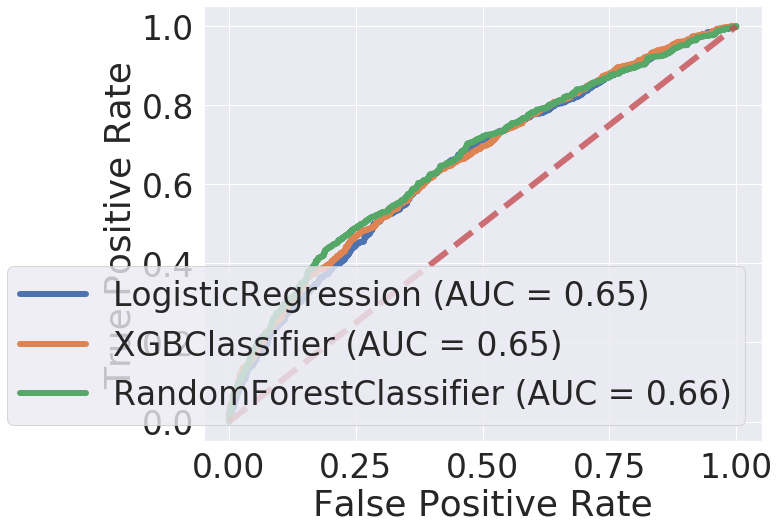

In [484]:
# Keep only the features that we want
# ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        'fav_win', 't0_prize', 't_0_avg_rating', 't1_prize', 't_1_avg_rating',
#        't0_prize_rating', 't1_prize_rating', 'rating_dif', 'prize_rating_dif']

# Drop all except prize_Rating_dif and rating_dif
# df_tmp = df_train.drop( ['rank_dif', 'history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )

# # Drop all except prize_Rating_dif and rating_dif and rank_dif
# df_tmp = df_train.drop( ['history_dif', 'shift_win_rate_0', 'shift_win_rate_1',
#        't_0_p_0_rating', 't_0_p_0_kast', 't_0_p_0_kpr',
#        't_0_p_1_rating', 't_0_p_1_kast', 't_0_p_1_kpr', 't_0_p_2_rating',
#        't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_rating', 't_0_p_3_kast',
#        't_0_p_3_kpr', 't_0_p_4_rating', 't_0_p_4_kast', 't_0_p_4_kpr',
#        't0_prize', 't_0_avg_rating', 't_1_p_0_rating', 't_1_p_0_kast',
#        't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
#        't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
#        't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
#        't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't0_prize_rating',
#        't1_prize_rating'], axis=1 )


df_tmp = df_train.drop(
    ['rank_dif', 'history_dif', 
       't_0_p_0_kast', 't_0_p_0_kpr',
       't_0_p_1_kast', 't_0_p_1_kpr', 
       't_0_p_2_kast', 't_0_p_2_kpr', 't_0_p_3_kast',
       't_0_p_3_kpr', 't_0_p_4_kast', 't_0_p_4_kpr',
       't0_prize',  't_1_p_0_kast',
       't_1_p_0_kpr',  't_1_p_1_kast', 't_1_p_1_kpr',
        't_1_p_2_kast', 't_1_p_2_kpr', 
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_kast',
       't_1_p_4_kpr', 't1_prize', 't_1_avg_rating', 't_1_avg_rating', 't0_prize_rating',
       't1_prize_rating' ],axis=1)

#df_tmp = df_train.drop([ 't0_prize', 't1_prize'],axis=1)

# Drop nothing
#df_tmp = df_train.drop(['rank_dif','t0_prize', 't1_prize','rating_dif','prize_rating_dif','t_1_avg_rating'],axis=1)

# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)


#X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['fav_win','rank_dif'],axis=1),df_train['fav_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1

#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
print(accuracy)

y_scores = logmodel.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_scores)


# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))





# Divide data set into training and testing sets      
#X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

clf = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=1,bootstrap=True)
clf.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))



# AUC ROC
sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(10,8));
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()

# Random Forest

In [480]:
# Divide data set into training and testing sets      
X_train, X_test, y_train, y_test = train_test_split(df_tmp.drop(['fav_win'],axis=1),df_tmp['fav_win'], test_size=0.25)

clf = RandomForestClassifier(n_estimators=20,max_depth=10, random_state=1,bootstrap=True)
clf.fit(X_train, y_train)
#RandomForestClassifier(max_depth=2, random_state=0)


# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = clf.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

>               precision    recall  f1-score   support

Underdog wins       0.57      0.30      0.39      1030
Favorite wins       0.65      0.86      0.74      1587

     accuracy                           0.64      2617
    macro avg       0.61      0.58      0.57      2617
 weighted avg       0.62      0.64      0.60      2617



In [255]:
# filename = 'model_jan30.sav'
# pickle.dump( logmodel, open(filename,'wb') )

In [256]:
df_tmp.head()

,fav_win,rating_dif,prize_rating_dif
79922,0,-0.023249,-0.090267
79923,0,-0.023249,-0.090267
79943,1,0.017754,0.113935
79945,0,0.017754,0.113935
79947,0,0.017754,0.113935


[[ 196  834]
 [ 146 1441]]
>               precision    recall  f1-score   support

Underdog wins       0.57      0.19      0.29      1030
Favorite wins       0.63      0.91      0.75      1587

     accuracy                           0.63      2617
    macro avg       0.60      0.55      0.52      2617
 weighted avg       0.61      0.63      0.56      2617



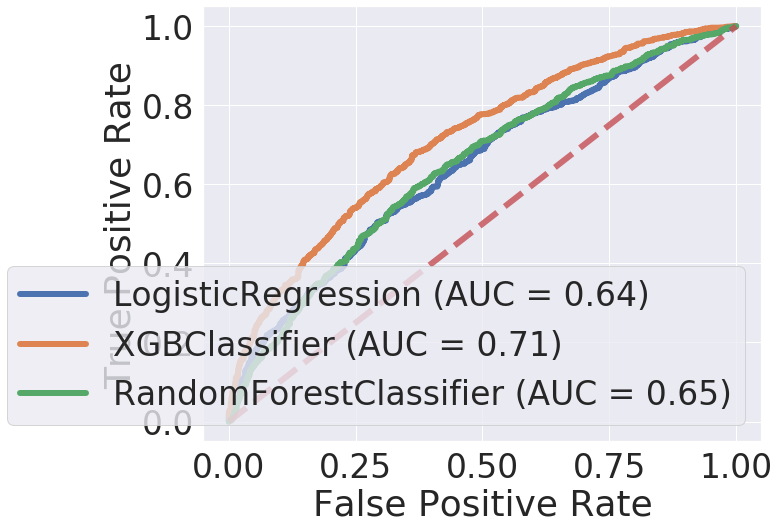

In [481]:
# Test with different tresholds
y_scores = logmodel.predict_proba(X_test)[:,1]
predictions = (y_scores > 0.5) *1
#print(predictions)

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))
roc_auc_score(y_test, y_scores)

sns.set_style("whitegrid")
sns.set(font_scale=3)

plt.figure(figsize=(10,8));
ax = plt.axes()
plot_roc_curve(logmodel, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(model, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

plot_roc_curve(clf, X_test, y_test, ax=ax, lw=6)  # doctest: +SKIP

ax.plot([0, 1], [0, 1], linestyle='--', lw=6, color='r',
        label='Chance', alpha=.8 )

plt.show()

In [436]:
logmodel.coef_

array([[ 0.69045349, -0.31595017,  0.6139815 ,  0.59129756,  0.85852741,
         0.56937936,  0.78637314,  0.68391179, -0.93851996, -0.29145401,
        -1.05008482, -0.35444881,  0.20436553,  1.16994021,  1.81494998]])

In [320]:
df_tmp.keys()

Index(['shift_win_rate_0', 'shift_win_rate_1', 'fav_win', 't_0_p_0_rating',
       't_0_p_0_kast', 't_0_p_0_kpr', 't_0_p_1_rating', 't_0_p_1_kast',
       't_0_p_1_kpr', 't_0_p_2_rating', 't_0_p_2_kast', 't_0_p_2_kpr',
       't_0_p_3_rating', 't_0_p_3_kast', 't_0_p_3_kpr', 't_0_p_4_rating',
       't_0_p_4_kast', 't_0_p_4_kpr', 't_1_p_0_rating', 't_1_p_0_kast',
       't_1_p_0_kpr', 't_1_p_1_rating', 't_1_p_1_kast', 't_1_p_1_kpr',
       't_1_p_2_rating', 't_1_p_2_kast', 't_1_p_2_kpr', 't_1_p_3_rating',
       't_1_p_3_kast', 't_1_p_3_kpr', 't_1_p_4_rating', 't_1_p_4_kast',
       't_1_p_4_kpr', 'rating_dif', 'prize_rating_dif'],
      dtype='object')